In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import re
from datetime import datetime
from dateutil import parser

def parse_num_of_people(s):
    # '내국인 :0명외국인 :0명 내국인 :0명 외국인 :0명'와 같은 문자열을 처리하기 위해
    # 정규표현식을 이용하여 '내국인 :숫자'와 '외국인 :숫자'를 추출합니다.
    regex = r'(내국인|외국인)\s*:\s*(\d+)명'
    matches = re.findall(regex, s)
    
    # 내국인과 외국인의 총 인원 수를 계산합니다.
    num_internal = 0
    num_foreign = 0
    for match in matches:
        if match[0] == '내국인':
            num_internal += int(match[1])
        elif match[0] == '외국인':
            num_foreign += int(match[1])
    result = (num_internal + num_foreign) / 2
    return result

# 발생 일시에서 월만 뽑아오는 함수
def extract_month(s):
    return int(s.split('-')[1])

# 시설물 종류 대분류 추출 함수
def extract_facility(s):
    return s.split('-')[0]

def extract_ratio(percent_str):
    try:
        # 문자열에서 % 값 추출
        percent = re.findall(r'\d+\.?\d*%', str(percent_str))[0]

        # % 값을 비율 값으로 변환
        if '~' in percent:
            # 30~39% 와 같은 경우
            ratio = float(percent.split('~')[1].replace('%', '')) / 100
        else:
            # 10% 미만 과 같은 경우
            ratio = float(percent.replace('%', '')) / 100

        return ratio
    
    except:
        return 0


def extract_population(population_str):
    try:
        # 문자열에서 사람 값 추출
        population = re.findall(r'\d+\.?\d*인', population_str)[0]

        if '~' in population:
            # 30~39인 과 같은 경우
            num = int(population.split('~')[1].replace('인', ''))
        else:
            # 10인 미만 과 같은 경우
            num = int(population.replace('인', ''))

        return num
    except:
        return 0

def extract_cost(cost_str):
    try:
        # 문자열에서 공사비 값 추출
        amount = re.findall(r'\d+\.?\d*d억', cost_str)[0]

        if '~' in amount:
            # 30~39억 과 같은 경우
            cost = int(amount.split('~')[1].replace('억', ''))
        else:
            # 10억 미만 과 같은 경우
            cost = int(amount.replace('억', ''))

        return cost
    except:
        return 0

def extract_damage(cost_str):
    try:
        if cost_str == "피해없음":
            return 0
        # 문자열에서 피해 금액 추출
        amount = re.findall(r'\d+\.?\d*d만', cost_str)[0]

        if '~' in amount:
            # 30~39억 과 같은 경우
            cost = int(amount.split('~')[1].replace('만', ''))
        else:
            # 10억 미만 과 같은 경우
            cost = int(amount.replace('만', ''))

        return cost
    except:
        return 0

# 날짜 수 세기 함수
def count_days(date_string):
    date_str = date_string.split('(해당공종')[0].strip()

    start_date = date_str.split(' ~ ')[0]
    end_date = date_str.split(' ~ ')[-1]
    start_date = parser.parse(start_date)
    end_date = parser.parse(end_date)

    return (end_date - start_date).days



#CSV 파일을 DataFrame으로 읽어오기


df = pd.read_csv('output.csv')
#필요 없는 특성 제거

allColumns = df.columns
params = ['발생일시','공공/민간 구분', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '피해금액', '공사비', '공사기간', '공정률', '작업자수', '설계안전성검토']

df = df.drop(allColumns.drop(params), axis=1)

#범주형 데이터를 수치형 데이터로 인코딩

df['사망자수(명)'] = df['사망자수(명)'].apply(parse_num_of_people)
df['부상자수(명)'] = df['부상자수(명)'].apply(parse_num_of_people)
df['발생일시'] = df['발생일시'].apply(extract_month)
df['시설물 종류'] = df['시설물 종류'].apply(extract_facility)
df['공사기간'] = df['공사기간'].apply(count_days)
df['공정률'] = df['공정률'].apply(extract_ratio)
df['작업자수'] = df['작업자수'].apply(extract_population)
df['공사비'] = df['공사비'].apply(extract_cost)
df['피해금액'] = df['피해금액'].apply(extract_damage)

# 기상 상태 컬럼 분리
df[['날씨', '기온', '습도']] = df['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
df = df.drop(['기상상태'], axis=1)

# print(df.head())

le = LabelEncoder()
df['공공/민간 구분'] = le.fit_transform(df['공공/민간 구분'])
df['설계안전성검토'] = le.fit_transform(df['설계안전성검토'])
df['날씨'] = le.fit_transform(df['날씨'])

#시설물 종류 특성을 원-핫 인코딩

ct = ColumnTransformer([
('ohe', OneHotEncoder(), ['시설물 종류'])
], remainder='passthrough')
X = ct.fit_transform(df)


#컬럼 이름 리스트 생성

num_cols = df.columns.tolist()
ohe = ct.named_transformers_['ohe']
ohe_cols = ohe.get_feature_names_out(['시설물 종류']).tolist()
new_cols = ohe_cols + num_cols
new_cols.remove('시설물 종류')
#DataFrame으로 변환

df = pd.DataFrame(X, columns=new_cols)

df = df.dropna()

df = df.astype('float64')

df['습도'] = df['습도'].apply(lambda x: x/100)

X = df.drop(['사망자수(명)'], axis=1)
y = df[['사망자수(명)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(10757, 16)
(1196, 16)


/Users/matmang/opt/anaconda3/envs/bert-study/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 0.0912348	training's rmse: 0.231167	valid_1's l1: 0.0972054	valid_1's rmse: 0.225552
Training until validation scores don't improve for 10 rounds
[2]	training's l1: 0.087603	training's rmse: 0.223517	valid_1's l1: 0.0934208	valid_1's rmse: 0.216469
[3]	training's l1: 0.0841567	training's rmse: 0.216384	valid_1's l1: 0.0897823	valid_1's rmse: 0.207799
[4]	training's l1: 0.0808703	training's rmse: 0.209715	valid_1's l1: 0.0863197	valid_1's rmse: 0.199653
[5]	training's l1: 0.0777556	training's rmse: 0.203539	valid_1's l1: 0.0830514	valid_1's rmse: 0.19211
[6]	training's l1: 0.0747359	training's rmse: 0.197692	valid_1's l1: 0.0799338	valid_1's rmse: 0.185094
[7]	training's l1: 0.0745182	training's rmse: 0.197168	valid_1's l1: 0.0797915	valid_1's rmse: 0.184881
[8]	training's l1: 0.0716813	training's rmse: 0.191836	valid_1's l1: 0.0768626	valid_1's rmse: 0.178514
[9]	training's l1: 0.0689744	training's rmse: 0.186864	valid_1's l1: 0.0740117	valid_1's rmse: 0.17231
[10]	t

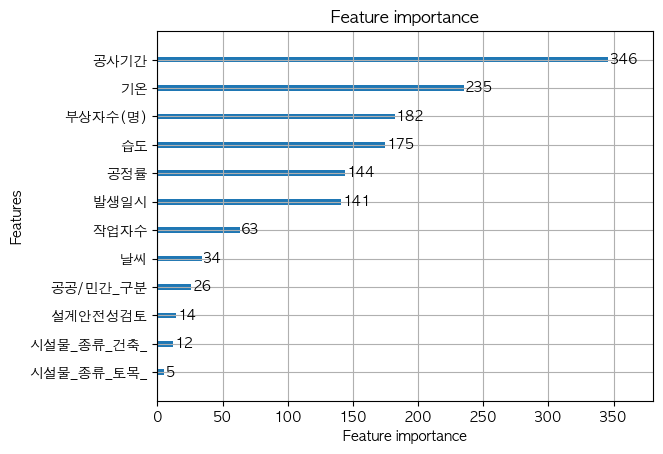

In [22]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': {'rmse', 'mae'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# 모델 학습
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10)

# 모델 예측
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.rcParams['font.family'] = 'AppleGothic'

# 모델 feature importance 출력
lgb.plot_importance(bst)
plt.show()

